<a href="https://colab.research.google.com/github/alawrence30/Deep-Learning/blob/main/Assignment%204/6_8_Assignment_4_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#https://www.kaggle.com/code/tilasousa/face-mask-detection-using-keras-cnn

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import cv2
from scipy.spatial import distance
import glob
from warnings import filterwarnings
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, load_model
from sklearn.metrics import classification_report , confusion_matrix
from skimage import io
filterwarnings("ignore")

from keras_preprocessing.image import img_to_array
from keras_preprocessing.image import load_img


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow_datasets as tfds
from keras import callbacks
from sklearn.metrics import accuracy_score
from os import listdir
from os.path import isfile, join

In [ ]:
## Accuracy and Loss Graph
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

## Validation Report
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

## Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

# defining callback function to avoid overfit
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 6, 
                                        restore_best_weights = True, verbose=1)

# EDA

The path is created for getting data and then I concatened dataframes of mask and without mask.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path  = '/content/gdrive/My Drive/MSDS 458/Assignment 4 - Final/Data/Face Mask Dataset/'

In [ ]:
# train dataset
train_dir = os.path.join(path, 'Train')

train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            batch_size=32,
                                                            image_size=(256,256),
                                                            shuffle=True)

Found 10000 files belonging to 2 classes.


In [ ]:
# validation dataset
validation_dir = os.path.join(path, 'Validation')

validation_ds = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                            batch_size=32,
                                                            image_size=(256,256),
                                                            shuffle=True)

Found 800 files belonging to 2 classes.


In [ ]:
# test dataset
test_dir = os.path.join(path, 'Test')

test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                            batch_size=32,
                                                            image_size=(256,256),
                                                            shuffle=True)

Found 992 files belonging to 2 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['WithMask', 'WithoutMask']


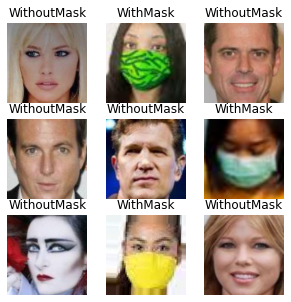

In [ ]:
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
# autotune buffer to avoid I/0 block
autotune = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=autotune)
validation_ds = validation_ds.cache().prefetch(buffer_size=autotune)

# Model 6

In [ ]:
model6 = Sequential()
tf.keras.layers.Rescaling(1./255),
model6.add(keras.layers.Flatten(input_shape = [256, 256, 3]))
model6.add(layers.Dense(units = 525, activation = "relu"))
model6.add(layers.Dense(units = 350, activation = "relu"))
model6.add(layers.Dense(units = 250, activation = "relu"))
model6.add(layers.Dense(units = 250, activation = "relu"))
model6.add(layers.Dense(name = "output_layer", units = 2, activation = "softmax"))

model6.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 196608)            0         
                                                                 
 dense_4 (Dense)             (None, 525)               103219725 
                                                                 
 dense_5 (Dense)             (None, 350)               184100    
                                                                 
 dense_6 (Dense)             (None, 250)               87750     
                                                                 
 dense_7 (Dense)             (None, 250)               62750     
                                                                 
 output_layer (Dense)        (None, 2)                 502       
                                                                 
Total params: 103,554,827
Trainable params: 103,554,82

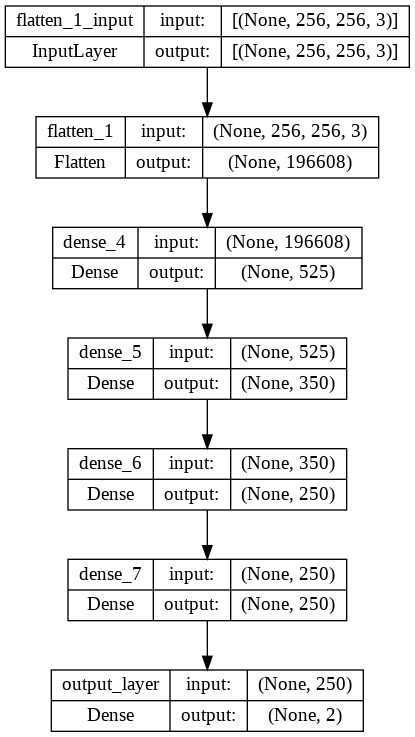

In [ ]:
keras.utils.plot_model(model6, "model6.png", show_shapes=True) 

In [ ]:
model6.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
## Train 
history6 = model6.fit(train_ds
                    ,validation_data =validation_ds
                    ,epochs=200
                    ,batch_size=64
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model6.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 3),
                    ]                                                                                                           
                   )

Epoch 1/200
313/313 [==============================] - 226s 715ms/step - loss: 745.8489 - accuracy: 0.7872 - val_loss: 15.8718 - val_accuracy: 0.9050
Epoch 2/200
313/313 [==============================] - 7s 21ms/step - loss: 29.4794 - accuracy: 0.8863 - val_loss: 5.4774 - val_accuracy: 0.9400
Epoch 3/200
313/313 [==============================] - 6s 19ms/step - loss: 12.8234 - accuracy: 0.9007 - val_loss: 4.0825 - val_accuracy: 0.9425
Epoch 4/200
313/313 [==============================] - 7s 23ms/step - loss: 16.8924 - accuracy: 0.8960 - val_loss: 3.0468 - val_accuracy: 0.8950
Epoch 5/200
313/313 [==============================] - 4s 12ms/step - loss: 6.1574 - accuracy: 0.9052 - val_loss: 3.6066 - val_accuracy: 0.9438
Epoch 6/200
313/313 [==============================] - 6s 18ms/step - loss: 3.0817 - accuracy: 0.9293 - val_loss: 2.0062 - val_accuracy: 0.9087
Epoch 7/200
313/313 [==============================] - 4s 12ms/step - loss: 2.9584 - accuracy: 0.9250 - val_loss: 4.1473 - val_

In [ ]:
model6 = tf.keras.models.load_model("DNN_model6.h5")
print(f"Test acc: {model6.evaluate(test_ds)[1]:.3f}")

31/31 [==============================] - 32s 749ms/step - loss: 2.2974 - accuracy: 0.8952
Test acc: 0.895


## Evaluate

In [ ]:
history_dict6 = history6.history
history_dict6.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df6=pd.DataFrame(history_dict6)
history_df6.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
3,16.892,0.896,3.047,0.895
4,6.157,0.905,3.607,0.944
5,3.082,0.929,2.006,0.909
6,2.958,0.925,4.147,0.875
7,3.715,0.910,2.221,0.934


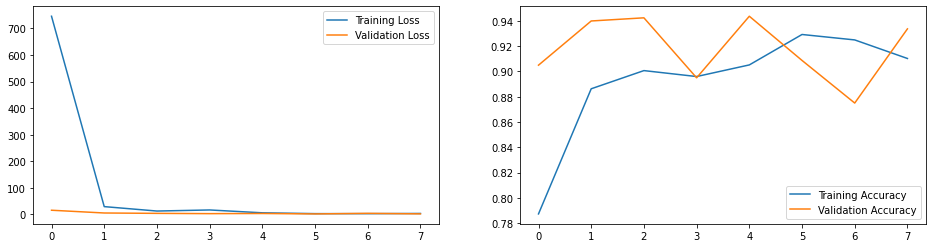

In [ ]:
## Loss and acuracy
plot_history(history6)

In [ ]:
test_pred6 = model6.predict(test_ds)
test_pred6 = np.argmax(test_pred6,axis = 1)
test_labels6 = np.concatenate([y for x, y in test_ds], axis=0) 

31/31 [==============================] - 1s 17ms/step


Text(0.5, 1.0, 'Confusion Matrix - Test Set')

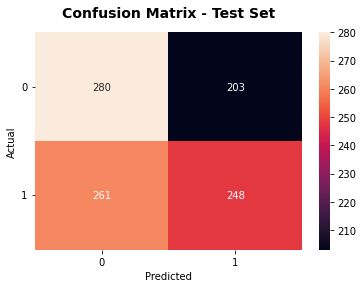

In [ ]:
plt.figure(figsize=(6, 4))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels6,
    test_pred6,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 10)
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 10) 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 14,weight = 'bold',pad=15)

In [ ]:
# 0 = without mask, 1 = with mask
# 992 images in test set, model missed 0 with mask and 483 without mask

In [ ]:
import numpy
from sklearn import metrics

actual6 = test_labels6
predicted6 = test_pred6

Accuracy = metrics.accuracy_score(actual6, predicted6)
Precision = metrics.precision_score(actual6, predicted6)
Sensitivity_recall = metrics.recall_score(actual6, predicted6)
Specificity = metrics.recall_score(actual6, predicted6, pos_label=0)
F1_score = metrics.f1_score(actual6, predicted6)

#metrics:
print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})

{'Accuracy': 0.532258064516129, 'Precision': 0.549889135254989, 'Sensitivity_recall': 0.48722986247544203, 'Specificity': 0.5797101449275363, 'F1_score': 0.5166666666666667}


In [ ]:
# report
labels = ['withMask', 'withoutMask']
print(classification_report(actual6, predicted6, target_names = labels))

              precision    recall  f1-score   support

    withMask       0.52      0.58      0.55       483
 withoutMask       0.55      0.49      0.52       509

    accuracy                           0.53       992
   macro avg       0.53      0.53      0.53       992
weighted avg       0.53      0.53      0.53       992



# Model 7


In [ ]:
model7 = Sequential()
tf.keras.layers.Rescaling(1./255),
model7.add(keras.layers.Flatten(input_shape = [256, 256, 3]))
model7.add(layers.Dense(units = 550, activation = "relu"))
model7.add(layers.Dense(units = 350, activation = "relu"))
model7.add(layers.Dense(units = 250, activation = "relu"))
model7.add(layers.Dense(units = 250, activation = "relu"))
model7.add(layers.Dense(name = "output_layer", units = 2, activation = "sigmoid"))

model7.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 196608)            0         
                                                                 
 dense_8 (Dense)             (None, 550)               108134950 
                                                                 
 dense_9 (Dense)             (None, 350)               192850    
                                                                 
 dense_10 (Dense)            (None, 250)               87750     
                                                                 
 dense_11 (Dense)            (None, 250)               62750     
                                                                 
 output_layer (Dense)        (None, 2)                 502       
                                                                 
Total params: 108,478,802
Trainable params: 108,478,80

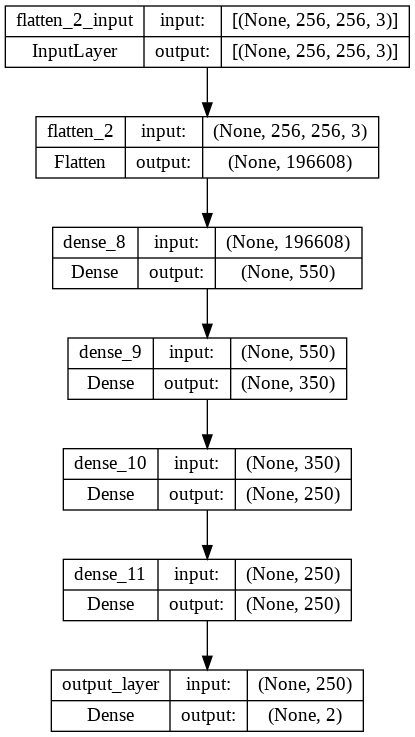

In [ ]:
keras.utils.plot_model(model7, "model7.png", show_shapes=True) 

In [ ]:
model7.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
## Train 
history7 = model7.fit(train_ds
                    ,validation_data =validation_ds
                    ,epochs=200
                    ,batch_size=64
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model7.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 3),
                    ]                                                                                                           
                   )

Epoch 1/200
313/313 [==============================] - 6s 19ms/step - loss: 713.1000 - accuracy: 0.7938 - val_loss: 54.5895 - val_accuracy: 0.8188
Epoch 2/200
313/313 [==============================] - 6s 20ms/step - loss: 68.1303 - accuracy: 0.8537 - val_loss: 8.8517 - val_accuracy: 0.9200
Epoch 3/200
313/313 [==============================] - 6s 19ms/step - loss: 14.6160 - accuracy: 0.9100 - val_loss: 5.3044 - val_accuracy: 0.9400
Epoch 4/200
313/313 [==============================] - 6s 19ms/step - loss: 7.9827 - accuracy: 0.9125 - val_loss: 4.1030 - val_accuracy: 0.9112
Epoch 5/200
313/313 [==============================] - 6s 20ms/step - loss: 11.1600 - accuracy: 0.9116 - val_loss: 4.0962 - val_accuracy: 0.8700
Epoch 6/200
313/313 [==============================] - 4s 12ms/step - loss: 16.8549 - accuracy: 0.8946 - val_loss: 6.9492 - val_accuracy: 0.9275


In [ ]:
model7 = tf.keras.models.load_model("DNN_model7.h5")
print(f"Test acc: {model7.evaluate(test_ds)[1]:.3f}")

31/31 [==============================] - 1s 22ms/step - loss: 3.5847 - accuracy: 0.8831
Test acc: 0.883


## Evaluate

In [ ]:
history_dict7 = history7.history
history_dict7.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df7=pd.DataFrame(history_dict7)
history_df7.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
1,68.130,0.854,8.852,0.920
2,14.616,0.910,5.304,0.940
3,7.983,0.913,4.103,0.911
4,11.160,0.912,4.096,0.870
5,16.855,0.895,6.949,0.928


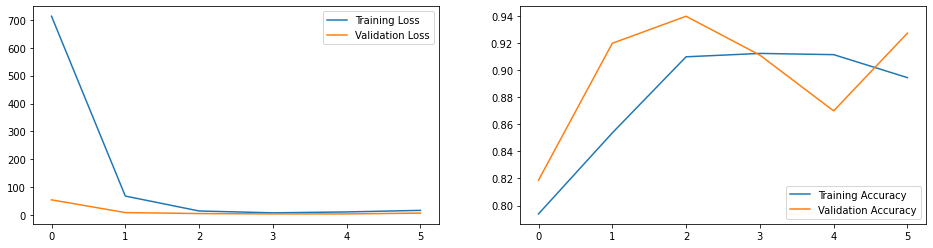

In [ ]:
## Loss and acuracy
plot_history(history7)

In [ ]:
test_pred7 = model7.predict(test_ds)
test_pred7 = np.argmax(test_pred7,axis = 1)
test_labels7 = np.concatenate([y for x, y in test_ds], axis=0) 

31/31 [==============================] - 2s 38ms/step


Text(0.5, 1.0, 'Confusion Matrix - Test Set')

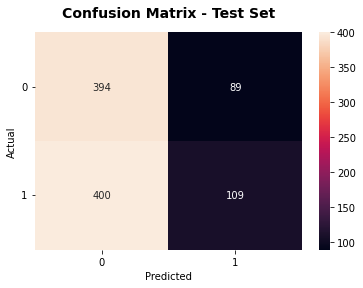

In [ ]:
plt.figure(figsize=(6, 4))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels7,
    test_pred7,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 10)
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 10) 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 14,weight = 'bold',pad=15)

In [ ]:
# 0 = without mask, 1 = with mask
# 992 images in test set, model missed 85 with mask and 403 without mask

In [ ]:
actual7 = test_labels7
predicted7 = test_pred7

Accuracy = metrics.accuracy_score(actual7, predicted7)
Precision = metrics.precision_score(actual7, predicted7)
Sensitivity_recall = metrics.recall_score(actual7, predicted7)
Specificity = metrics.recall_score(actual7, predicted7, pos_label=0)
F1_score = metrics.f1_score(actual7, predicted7)

#metrics:
print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})

{'Accuracy': 0.5070564516129032, 'Precision': 0.5505050505050505, 'Sensitivity_recall': 0.21414538310412573, 'Specificity': 0.8157349896480331, 'F1_score': 0.3083451202263084}


In [ ]:
# report
labels = ['withMask', 'withoutMask']
print(classification_report(actual7, predicted7, target_names = labels))

              precision    recall  f1-score   support

    withMask       0.50      0.82      0.62       483
 withoutMask       0.55      0.21      0.31       509

    accuracy                           0.51       992
   macro avg       0.52      0.51      0.46       992
weighted avg       0.52      0.51      0.46       992



# Model 8

In [ ]:
model8 = Sequential()
tf.keras.layers.Rescaling(1./255),
model8.add(keras.layers.Flatten(input_shape = [256, 256, 3]))
model8.add(layers.Dense(units = 650, activation = "relu"))
model8.add(layers.Dense(units = 550, activation = "relu"))
model8.add(layers.Dense(units = 450, activation = "relu"))
model8.add(layers.Dense(units = 350, activation = "relu"))
model8.add(layers.Dense(name = "output_layer", units = 2, activation = "sigmoid"))

model8.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 196608)            0         
                                                                 
 dense_16 (Dense)            (None, 650)               127795850 
                                                                 
 dense_17 (Dense)            (None, 550)               358050    
                                                                 
 dense_18 (Dense)            (None, 450)               247950    
                                                                 
 dense_19 (Dense)            (None, 350)               157850    
                                                                 
 output_layer (Dense)        (None, 2)                 702       
                                                                 
Total params: 128,560,402
Trainable params: 128,560,40

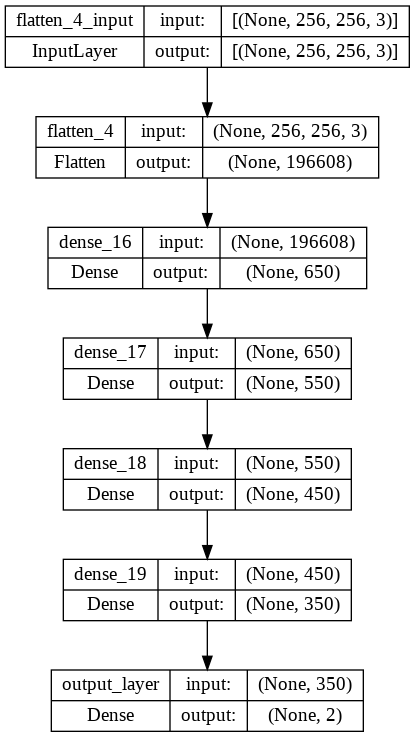

In [ ]:
keras.utils.plot_model(model8, "model8.png", show_shapes=True) 

In [ ]:
model8.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
## Train 
history8 = model8.fit(train_ds
                    ,validation_data =validation_ds
                    ,epochs=200
                    ,batch_size=64
                    ,callbacks=[
                     tf.keras.callbacks.ModelCheckpoint("DNN_model8.h5",save_best_only=True,save_weights_only=False) 
                     ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience = 3),
                    ]                                                                                                           
                   )

Epoch 1/200
313/313 [==============================] - 8s 25ms/step - loss: 1038.2269 - accuracy: 0.7758 - val_loss: 6.3285 - val_accuracy: 0.8900
Epoch 2/200
313/313 [==============================] - 7s 23ms/step - loss: 12.9527 - accuracy: 0.8858 - val_loss: 4.0460 - val_accuracy: 0.9062
Epoch 3/200
313/313 [==============================] - 4s 13ms/step - loss: 7.5180 - accuracy: 0.9040 - val_loss: 5.3035 - val_accuracy: 0.9212
Epoch 4/200
313/313 [==============================] - 4s 13ms/step - loss: 13.4607 - accuracy: 0.8718 - val_loss: 17.0672 - val_accuracy: 0.7738
Epoch 5/200
313/313 [==============================] - 7s 24ms/step - loss: 8.8456 - accuracy: 0.9096 - val_loss: 1.9833 - val_accuracy: 0.9375
Epoch 6/200
313/313 [==============================] - 7s 23ms/step - loss: 2.8121 - accuracy: 0.9291 - val_loss: 1.0158 - val_accuracy: 0.9563
Epoch 7/200
313/313 [==============================] - 4s 13ms/step - loss: 3.1966 - accuracy: 0.9263 - val_loss: 1.1133 - val_acc

In [ ]:
model8 = tf.keras.models.load_model("DNN_model8.h5")
print(f"Test acc: {model8.evaluate(test_ds)[1]:.3f}")

31/31 [==============================] - 1s 17ms/step - loss: 0.6910 - accuracy: 0.5171
Test acc: 0.517


## Evaluate

In [ ]:
history_dict8 = history8.history
history_dict8.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
history_df8=pd.DataFrame(history_dict8)
history_df8.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
4,8.846,0.910,1.983,0.938
5,2.812,0.929,1.016,0.956
6,3.197,0.926,1.113,0.941
7,6.241,0.902,6.743,0.881
8,8.533,0.579,0.690,0.507


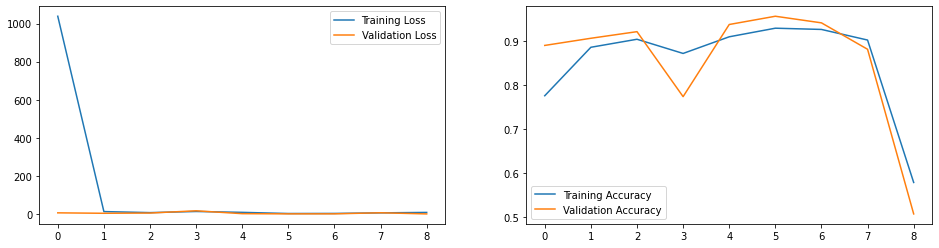

In [ ]:
## Loss and acuracy
plot_history(history8)

In [ ]:
test_pred8 = model8.predict(test_ds)
test_pred8 = np.argmax(test_pred8,axis = 1)
test_labels8 = np.concatenate([y for x, y in test_ds], axis=0) 

31/31 [==============================] - 1s 16ms/step


Text(0.5, 1.0, 'Confusion Matrix - Test Set')

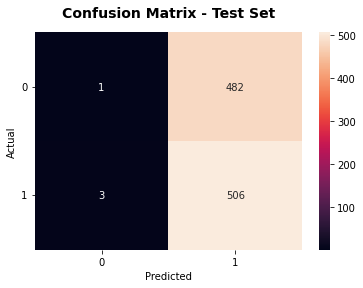

In [ ]:
plt.figure(figsize=(6, 4))
ax = sns.heatmap(tf.math.confusion_matrix(
    test_labels8,
    test_pred8,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
),annot = True,
  fmt="d")
ax.set_xlabel('Predicted',fontsize = 10)
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 10) 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 14,weight = 'bold',pad=15)

In [ ]:
# 0 = without mask, 1 = with mask
# 992 images in test set, model missed 82 with mask and 403 without mask

In [ ]:
actual8 = test_labels8
predicted8 = test_pred8

Accuracy = metrics.accuracy_score(actual8, predicted8)
Precision = metrics.precision_score(actual8, predicted8)
Sensitivity_recall = metrics.recall_score(actual8, predicted8)
Specificity = metrics.recall_score(actual8, predicted8, pos_label=0)
F1_score = metrics.f1_score(actual8, predicted8)

#metrics:
print({"Accuracy":Accuracy,"Precision":Precision,"Sensitivity_recall":Sensitivity_recall,"Specificity":Specificity,"F1_score":F1_score})

{'Accuracy': 0.5110887096774194, 'Precision': 0.5121457489878543, 'Sensitivity_recall': 0.9941060903732809, 'Specificity': 0.002070393374741201, 'F1_score': 0.6760187040748163}


In [ ]:
# report
labels = ['withMask', 'withoutMask']
print(classification_report(actual8, predicted8, target_names = labels))

              precision    recall  f1-score   support

    withMask       0.25      0.00      0.00       483
 withoutMask       0.51      0.99      0.68       509

    accuracy                           0.51       992
   macro avg       0.38      0.50      0.34       992
weighted avg       0.38      0.51      0.35       992

